# CNN model notebook

Import libraries and modules

In [1]:
# move to the root directory of the git
%cd ..

C:\Users\DJNaj\Documents\CiTG\MSc\Year II\Q2\CEGM2003 - Data Science and Artificial Intelligence for Engineers\Unit 3 - Project\FLOOD_group2


In [2]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
#import imageio
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data.dataset import random_split
import torch.nn as nn
from torchsummary import summary
from torchviz import make_dot
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from matplotlib.colors import TwoSlopeNorm
import random
from IPython.display import Image, display

from pre_processing.encode_decode_csv import decode_from_csv

from pre_processing.process_data import *
from models.CNN_model.CNN_functions import *
from models.CNN_model.CNN_classes import *
from pre_processing.augmentation import *
from pre_processing.normalization import * 

# Creating Training Dataset

First the training dataset is created based upon a research paper by Bentivoglio et al (2023). For training and validation purposes a dataset of 80 different generated digital elevation models are used to reflect different plausible topographies. The velocity in both x and y direction (VX and VY) as well as the water depth (WD) are known, based on numerical computations utilizing Delft3D.

The code cell below uses two custom functions for the elevation data processing and water depth processing. 

<b>Elevation Data Processing</b>

The process_elevation_data function takes a DEM (Digital Elevation Model) file identifier (file_id) and a dataset identifier (dataset_id) as inputs. It reads the corresponding DEM file, extracts elevation data, and calculates the slope in the x and y directions. The result is a torch tensor combining the original elevation data with its slope information.

<b>Water Depth Processing</b>

The process_water_depth function processes water depth data from a specific time step in a file. It requires a water depth file identifier (file_id), a dataset identifier (dataset_id), and an optional time step parameter (time_step, default is 0). The function reads the specified file, extracts the data for the given time step, and returns a 64x64 torch tensor representing water depth.

In [3]:
# Specify the time t0 and t
t0 = 0
t = 1

train_dataset = []

for i in range(1, 81):  # Loop through file IDs from DEM_1 to DEM_80
    file_id = i
    
    # Input Tensor (input_tensor.shape will be [4, 64, 64])
    elevation_slope_tensor = process_elevation_data(file_id, 'train/val')
    water_depth_input_tensor = process_water_depth(file_id, 'train/val', time_step=t0)  # Time Step is t0
    water_depth_input_tensor = torch.unsqueeze(water_depth_input_tensor, 0)
    
    input_tensor = torch.cat((elevation_slope_tensor, water_depth_input_tensor), dim=0)
    input_tensor = input_tensor.double()
    
    # Output Sequence Tensor (output_sequence_tensor.shape will be [48, 64, 64])
    output_tensors = []
    for time_step_index in range(1, 96, 2):  # Loop through every even time step out of the 96
        water_depth_output_tensor = process_water_depth(file_id, 'train/val', time_step=t0 + time_step_index)
        output_tensors.append(water_depth_output_tensor)
    
    output_sequence_tensor = torch.stack(output_tensors, dim=0)
    output_sequence_tensor = output_sequence_tensor.double()
    
    # Create a tuple
    train_dataset_sample = (input_tensor, output_sequence_tensor)
    
    # Append the sample to the train_dataset list
    train_dataset.append(train_dataset_sample)

In [4]:
# Printing a few samples to verify the shape of train input and output tensors

for i, sample in enumerate(train_dataset[:5]):  # Print shapes for the first 5 samples
    input_train_tensor, output_train_sequence_tensor = sample
    
    print(f"Sample {i+1}:")
    print("Input Train Tensor Shape:", input_train_tensor.shape)
    print("Output Train Sequence Tensor Shape:", output_train_sequence_tensor.shape)
    print()

Sample 1:
Input Train Tensor Shape: torch.Size([4, 64, 64])
Output Train Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 2:
Input Train Tensor Shape: torch.Size([4, 64, 64])
Output Train Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 3:
Input Train Tensor Shape: torch.Size([4, 64, 64])
Output Train Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 4:
Input Train Tensor Shape: torch.Size([4, 64, 64])
Output Train Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 5:
Input Train Tensor Shape: torch.Size([4, 64, 64])
Output Train Sequence Tensor Shape: torch.Size([48, 64, 64])



In [5]:
# # Select a random sample from the dataset
# sample_index = random.randint(0, len(train_dataset) - 1)
# print(sample_index)
# input_tensor, output_sequence_tensor = train_dataset[sample_index]

# # Plot input tensors (DEM, slope x, slope y, water depth at initial time step)
# fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# # Plot DEM (Terrain) with appropriate colormap
# axs[0].imshow(input_tensor[0], cmap='terrain')
# axs[0].set_title('DEM (Terrain)')

# # Plot slope x and slope y with 'coolwarm' colormap
# for i in range(1, 3):
#     axs[i].imshow(input_tensor[i], cmap='coolwarm')
#     axs[i].set_title(f'Slope {"X" if i == 1 else "Y"}')

# # Plot water depth at initial time step and output at a random time step with 'Blues' colormap
# axs[3].imshow(input_tensor[3], cmap='Blues')
# axs[3].set_title('Water Depth (Initial Time Step)')

# # Select a random time step from the output sequence tensor
# random_time_step = random.randint(0, output_sequence_tensor.shape[0] - 1)
# output_at_time_step = output_sequence_tensor[random_time_step]

# # Plot the output at the random time step
# axs[4].imshow(output_at_time_step, cmap='Blues')
# axs[4].set_title(f'Output at Time Step {random_time_step}')

# plt.tight_layout()
# plt.show()


# Creating the Test Dataset

Now the test dataset is created based on dataset1 from Bentivoglio et al (2023). This dataset features 20 DEMs over a squared domain of 64x64 grids of length 100 m and a simulation time of 48 h. A fixed breach location is used.

In [6]:
# Specify the time t0 and t
t0 = 0
t = 1

# Loop through file IDs from DEM_1 to DEM_80
test_dataset = []

for i in range(500, 520):  # Assuming file IDs are numbered from 500 to 520
    file_id = i
    
    # Input Tensor (input_tensor.shape will be [4, 64, 64])
    elevation_slope_tensor = process_elevation_data(file_id, 'dataset1')
    water_depth_input_tensor = process_water_depth(file_id, 'dataset1', time_step=t0)  # Time Step is t0
    # Add an extra dimension to make water_depth_tensor [1, 64, 64]
    water_depth_input_tensor = torch.unsqueeze(water_depth_input_tensor, 0)
    
    # Concatenate to create the input tensor
    input_test_tensor = torch.cat((elevation_slope_tensor, water_depth_input_tensor), dim=0)
    input_test_tensor = input_test_tensor.double()
    
    # Output Sequence Tensor (output_sequence_tensor.shape will be [48, 64, 64])
    output_test_tensors = []
    for time_step_index in range(1,96,2):  # Loop through every even time step out of the 96
        water_depth_output_tensor = process_water_depth(file_id, 'dataset1', time_step=t0 + time_step_index)
        output_test_tensors.append(water_depth_output_tensor)
    
    # Stack the list of output tensors along the new time dimension to create a sequence
    output_test_sequence_tensor = torch.stack(output_test_tensors, dim=0)
    output_test_sequence_tensor = output_test_sequence_tensor.double()
    
    # Create a tuple
    test_dataset_sample = (input_test_tensor, output_test_sequence_tensor)
    
    # Append the sample to the test_dataset list
    test_dataset.append(test_dataset_sample)

In [7]:
# Printing a few samples to verify the shape of test input and output tensors

for i, sample in enumerate(test_dataset[:5]):  # Print shapes for the first 5 samples
    input_test_tensor, output_test_sequence_tensor = sample
    
    print(f"Sample {i+1}:")
    print("Input Test Tensor Shape:", input_test_tensor.shape)
    print("Output Test Sequence Tensor Shape:", output_test_sequence_tensor.shape)
    print()

Sample 1:
Input Test Tensor Shape: torch.Size([4, 64, 64])
Output Test Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 2:
Input Test Tensor Shape: torch.Size([4, 64, 64])
Output Test Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 3:
Input Test Tensor Shape: torch.Size([4, 64, 64])
Output Test Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 4:
Input Test Tensor Shape: torch.Size([4, 64, 64])
Output Test Sequence Tensor Shape: torch.Size([48, 64, 64])

Sample 5:
Input Test Tensor Shape: torch.Size([4, 64, 64])
Output Test Sequence Tensor Shape: torch.Size([48, 64, 64])



In [8]:
# # Select a random sample from the dataset
# sample_index = random.randint(0, len(test_dataset) - 1)
# input_test_tensor, output_test_sequence_tensor = test_dataset[sample_index]

# # Plot input tensors (DEM, slope x, slope y, water depth at initial time step)
# fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# # Plot DEM (Terrain) with appropriate colormap
# axs[0].imshow(input_tensor[0], cmap='terrain')
# axs[0].set_title('DEM (Terrain)')

# # Plot slope x and slope y with 'coolwarm' colormap
# for i in range(1, 3):
#     axs[i].imshow(input_test_tensor[i], cmap='coolwarm')
#     axs[i].set_title(f'Slope {"X" if i == 1 else "Y"}')

# # Plot water depth at initial time step and output at a random time step with 'Blues' colormap
# axs[3].imshow(input_test_tensor[3], cmap='Blues')
# axs[3].set_title('Water Depth (Initial Time Step)')

# # Select a random time step from the output sequence tensor
# random_time_step = random.randint(0, output_sequence_tensor.shape[0] - 1)
# output_test_at_time_step = output_test_sequence_tensor[random_time_step]

# # Plot the output at the random time step
# axs[4].imshow(output_test_at_time_step, cmap='Blues')
# axs[4].set_title(f'Output at Time Step {random_time_step}')

# plt.tight_layout()
# plt.show()


# Aplying Data augmentation

In [9]:
# # apply augmentation
# transformed_dataset = augmentation(train_dataset)

# Splitting the Datasets

Below, the training dataset is split into training and validation sets. A standard 80/20 split is employed. 

In [10]:
train_percent = 0.8
train_size = int(train_percent * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data Normalization

In [11]:
def normalize_dataset(dataset, scaler_x, scaler_y):
    # Extract min and max values from the scalers for inputs and outputs
    min_x, max_x = scaler_x.data_min_[0], scaler_x.data_max_[0]
    min_y, max_y = scaler_y.data_min_[0], scaler_y.data_max_[0]

    normalized_dataset = []
    for idx in range(len(dataset)):
        x = dataset[idx][0]
        y_sequence = dataset[idx][1]

        # Normalize input (assuming it's a single tensor)
        norm_x = (x - min_x) / (max_x - min_x)

        # Normalize each output sequence tensor individually
        normalized_sequence = []
        for t in range(y_sequence.shape[0]):
            norm_y = (y_sequence[t] - min_y) / (max_y - min_y)
            normalized_sequence.append(norm_y)

        normalized_dataset.append((norm_x, torch.stack(normalized_sequence)))

    return normalized_dataset


In [12]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scalers using the training dataset
for idx in range(len(train_dataset)):
    scaler_x.partial_fit(train_dataset[idx][0].flatten().unsqueeze(0).T.cpu())
    scaler_y.partial_fit(train_dataset[idx][1].flatten().unsqueeze(0).T.cpu())

# Normalize the datasets
normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_y)
normalized_val_dataset = normalize_dataset(val_dataset, scaler_x, scaler_y)
normalized_test_dataset = normalize_dataset(test_dataset, scaler_x, scaler_y)


In [13]:
# Assuming normalized_train_dataset and normalized_test_dataset are your normalized datasets

# Print the minimum and maximum values for input and output sequences in the first sample of the normalized training dataset
input_sample, output_sample = normalized_train_dataset[0]
print("Input Min-Max:", input_sample[0].min().item(), "-", input_sample[0].max().item())
print("Output Min-Max:", output_sample.min().item(), "-", output_sample.max().item())


Input Min-Max: 0.19037160092460595 - 0.8353498648939646
Output Min-Max: 0.0 - 0.6252729777184661


# Model summary and visualization

Now the CNN model is instantiated and a summary of the model is printed. Please refer to the '‘CNN_classes.py’' file within the CNN_model directory for further details on the defining of the CNN architecture. The model resembles a U-Net, consisting of an encoder and a corresponding decoder, connected by a bottleneck layer. In total, the model has 124,128,688 parameters, all of which are trainable.
The key components of the model architecture are:


<b>Encoder</b>

The encoder consists of multiple layers of convolution and pooling operations, gradually reducing spatial dimensions while increasing feature channels:

•	The model starts with a convolutional layer (Conv2d-1) followed by batch normalization (BatchNorm2d-2) and Rectified Linear Unit (ReLU-3).

•	This is followed by another set of convolution, batch normalization, and ReLU (DoubleConv-7).

•	Max pooling (MaxPool2d-8) is applied to reduce spatial dimensions.

•	The model then repeats the encoder structure, gradually increasing the number of channels in each block (Down-16, Down-25, Down-35).


<b>Decoder</b>

The decoder, comprised of up-sampling and convolutional layers, reconstructs the high-resolution segmentation map from the learned features:

•	The decoder begins with upsampling using transposed convolution (ConvTranspose2d-44) followed by a series of convolution, batch normalization, and ReLU operations (DoubleConv-51).

•	This process is repeated for each level of the decoder (Up-52, Up-61, Up-70, Up-79).


<b>Skip connections</b>

Skip connections are established between corresponding encoder and decoder layers, which enhance information flow between different resolutions; facilitating the preservation of fine details and improving the training stability.

In [15]:
# Instantiate the CNN
model = UNet().to(device)
summary(model, input_size=(4, 64, 64)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           4,608
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]         147,456
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              ReLU-6          [-1, 128, 64, 64]               0
        DoubleConv-7          [-1, 128, 64, 64]               0
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         294,912
      BatchNorm2d-10          [-1, 256, 32, 32]             512
             ReLU-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 256, 32, 32]         589,824
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1, 256,

Below, the model architecture is visualized using PyTorchViz. PyTorchViz uses the following color-coding the model architecture graph:

•	Blue nodes represent tensors or variables in the computation graph. These are the data elements that flow through the operations.

•	Gray nodes represent PyTorch functions or operations performed on tensors.

•	Green nodes represent gradients or derivatives of tensors. They showcase the backpropagation flow of gradients through the computation graph.

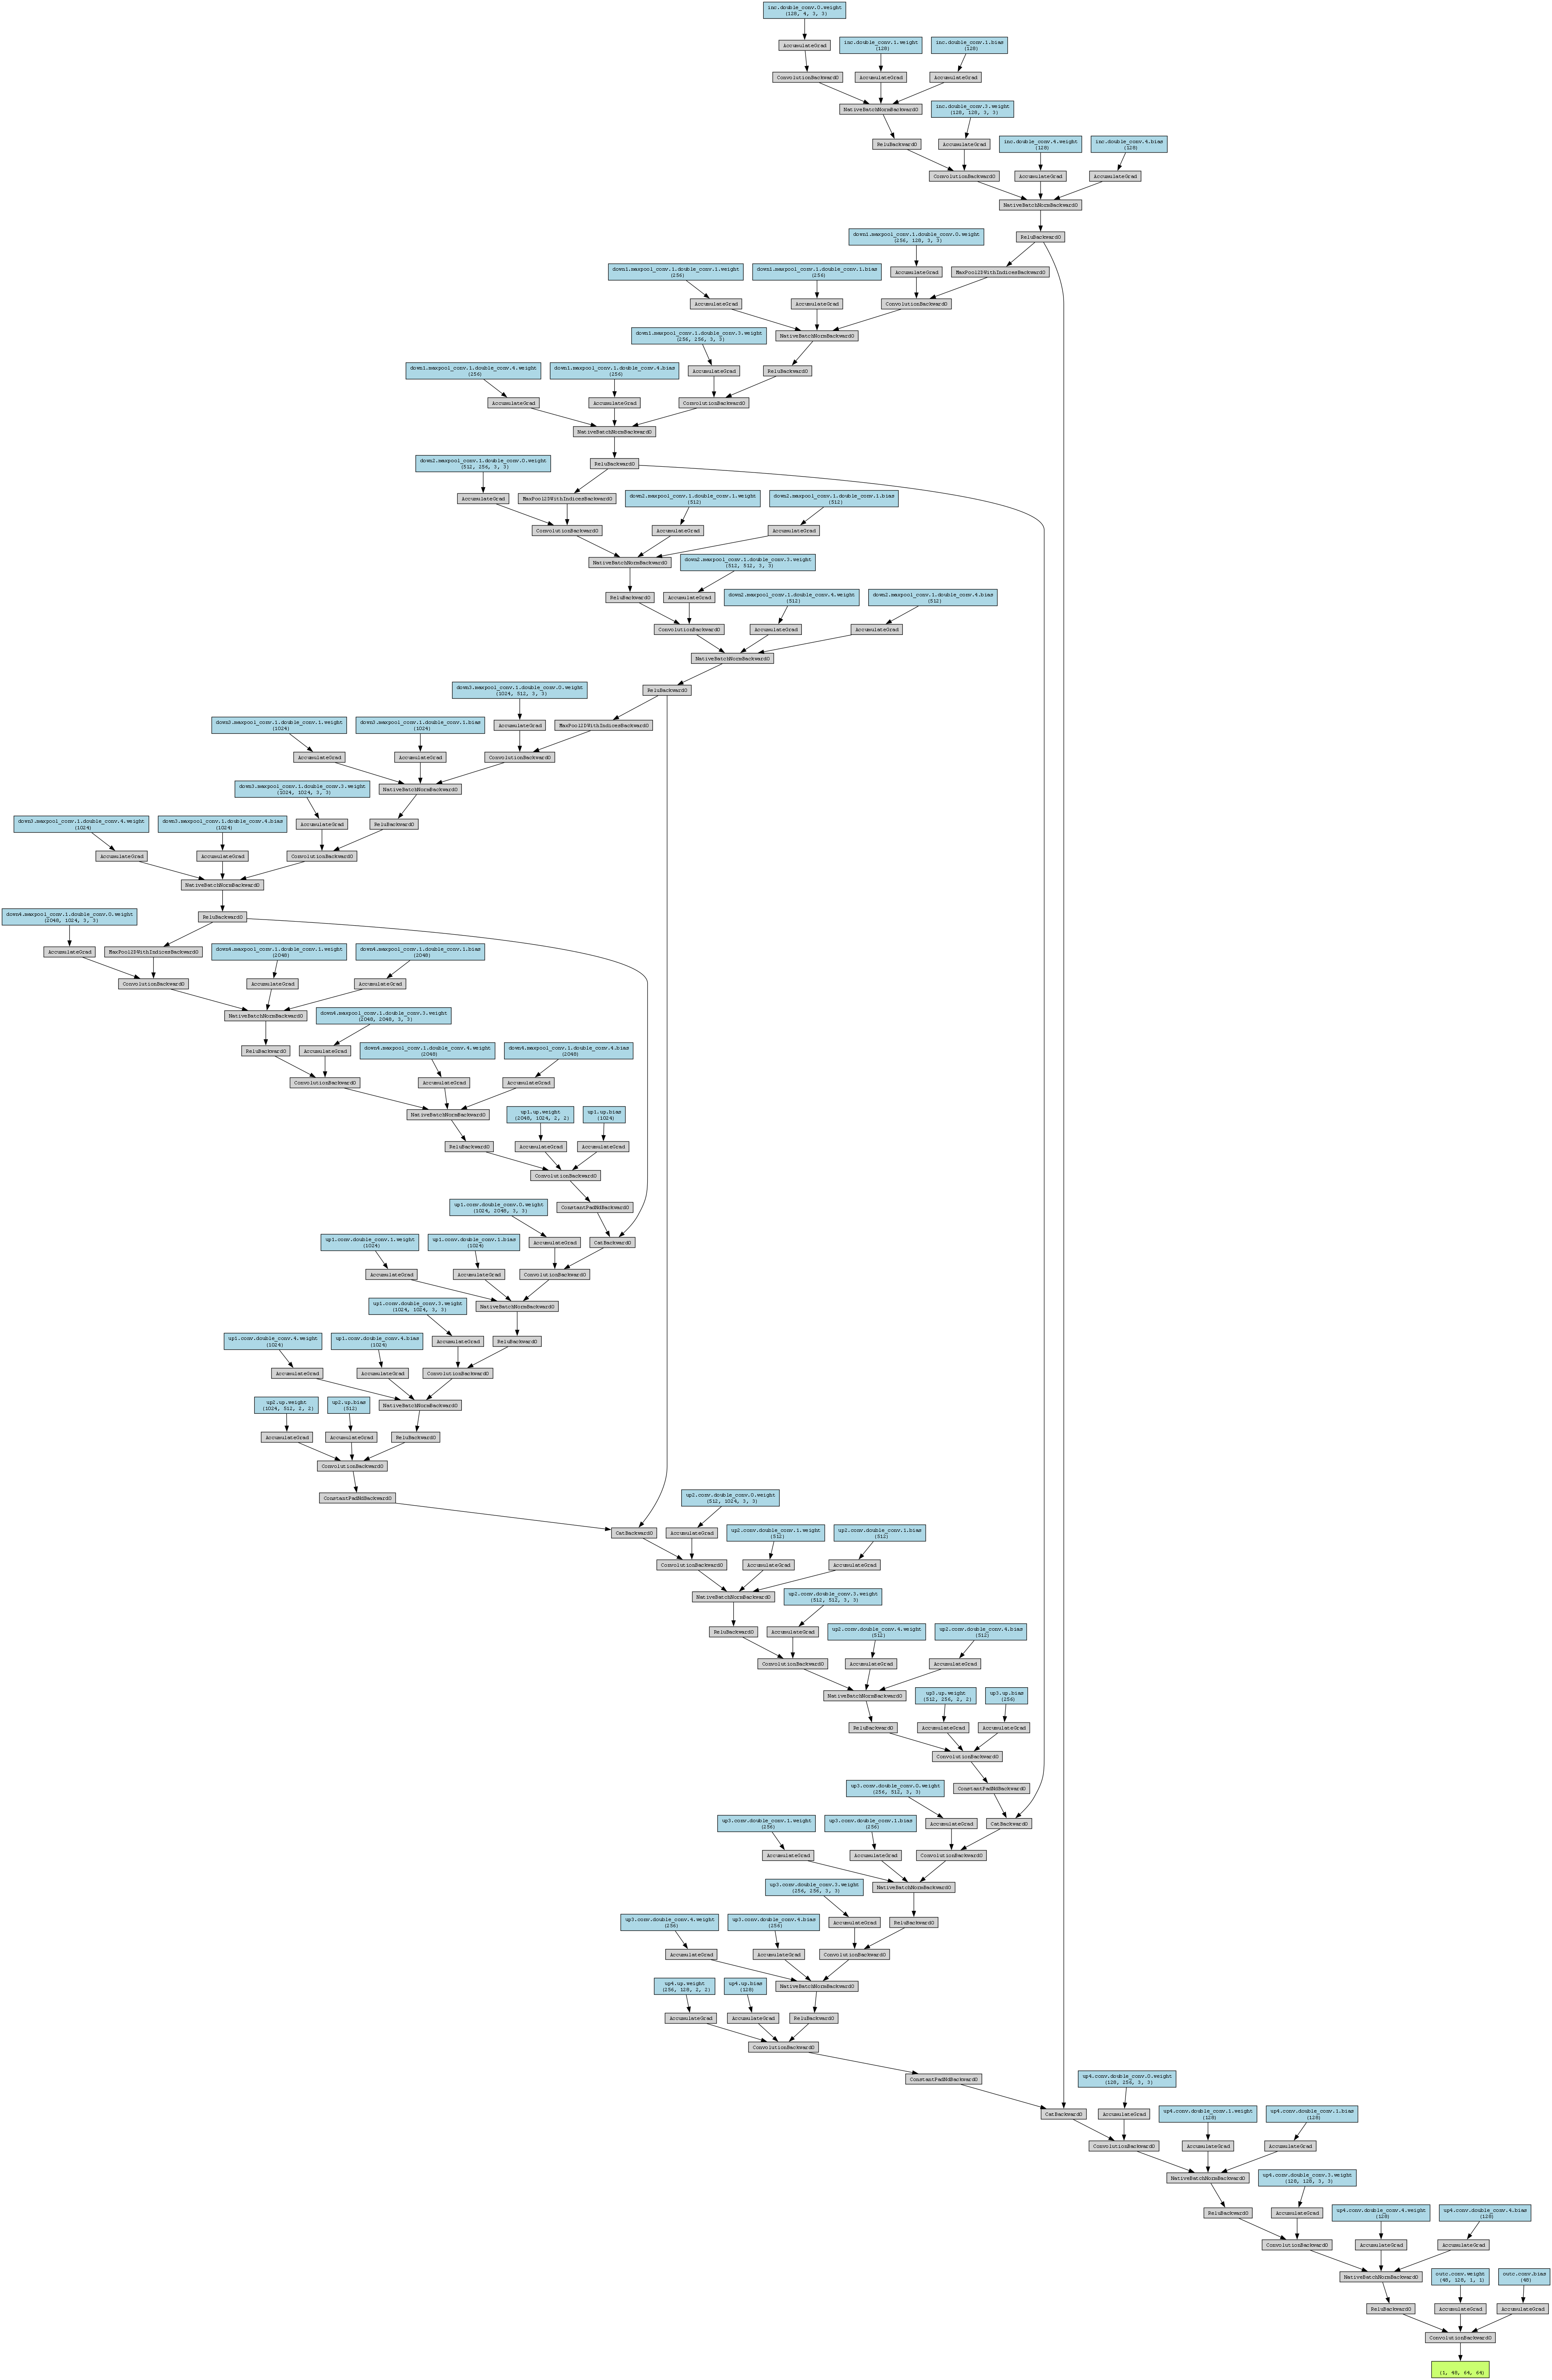

In [16]:
# Visualize the model architecture
dummy_input = torch.randn(1, 4, 64, 64).to(device)
model.eval()  # Set the model to evaluation mode
out = model(dummy_input)
graph = make_dot(out, params=dict(model.named_parameters()))
output_path = os.path.join('images', 'CNN_model_graph')
graph.render(output_path, format="png", cleanup=True)
img_path = f"{output_path}.png"
display(Image(filename=img_path))

# Model training

<b>Training Parameters</b>

First the learning rate, batch size, and the number of training epochs are specified.

In [17]:
# Set training parameters
learning_rate = 0.001
batch_size = 64
num_epochs = 100

<b>Optimizer and Dataloaders</b>

An Adam optimizer is set up to train the neural network, and dataloaders are created to efficiently handle batches of data during training and evaluation.

In [18]:
# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(normalized_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(normalized_val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(normalized_test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
train_dataset[0][1].shape

torch.Size([48, 64, 64])

<b>Training and Evaluation Loops</b>

Here, we iterate over epochs, conducting both training and validation loops. Losses are computed and stored for each epoch, with periodic printing for monitoring.

The code cell below uses two custom functions for training and evaluating:

<b>train_epoch</b>

The train_epoch function is used for training the model. It takes as input the model architecture (model), a data loader (loader) supplying training batches, an optimizer (optimizer) for weight updates, and the computation device (device). During each training epoch, the function iterates through the provided data loader, performs forward and backward passes, computes Mean Squared Error (MSE) loss, and updates the model parameters using backpropagation.

<b>evaluation</b>

The evaluation function is used for assessing the model's performance on a validation or test dataset. Similar to train_epoch, it takes the model (model), a data loader (loader), and the computation device (device) as inputs. However, it operates in evaluation mode, meaning it disables gradient computation and only performs forward passes to compute MSE loss on the validation or test set.

In [21]:
# # Apostolos original code
# train_losses = []
# validation_losses = []

# for epoch in range(num_epochs):
#     # Training loop
#     train_loss = train_epoch(model, train_loader, optimizer, device=device)
#     train_losses.append(train_loss)

#     # Validation loop
#     validation_loss = evaluation(model, val_loader, device=device)
#     validation_losses.append(validation_loss)

#     # Print the loss for every 10 epochs
#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Validation Loss: {validation_loss:.4f}')

Epoch 10 | Train Loss: 0.0113 | Validation Loss: 0.0696
Epoch 20 | Train Loss: 0.0061 | Validation Loss: 0.0063
Epoch 30 | Train Loss: 0.0043 | Validation Loss: 0.0047
Epoch 40 | Train Loss: 0.0029 | Validation Loss: 0.0032
Epoch 50 | Train Loss: 0.0022 | Validation Loss: 0.0037
Epoch 60 | Train Loss: 0.0019 | Validation Loss: 0.0031
Epoch 70 | Train Loss: 0.0018 | Validation Loss: 0.0029
Epoch 80 | Train Loss: 0.0015 | Validation Loss: 0.0021
Epoch 90 | Train Loss: 0.0013 | Validation Loss: 0.0030
Epoch 100 | Train Loss: 0.0012 | Validation Loss: 0.0024


In [32]:
# David test including early stopping
train_losses = []
validation_losses = []

best_validation_loss = float('inf')  # Initialize with a very large value
patience = 10  # Number of epochs with no improvement after which training will be stopped

for epoch in range(num_epochs):
    # Training loop
    train_loss = train_epoch(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)

    # Validation loop
    validation_loss = evaluation(model, val_loader, device=device)
    validation_losses.append(validation_loss)

    # Print the loss for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Validation Loss: {validation_loss:.4f}')

    # Check for early stopping
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        patience_counter = 0  # Reset patience counter since there is an improvement
    else:
        patience_counter += 1  # No improvement, increase the patience counter

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1} | Best Validation Loss: {best_validation_loss:.4f}')
        break  # Stop training

Epoch 10 | Train Loss: 0.0012 | Validation Loss: 0.0024
Epoch 20 | Train Loss: 0.0009 | Validation Loss: 0.0020
Early stopping at epoch 28 | Best Validation Loss: 0.0018


<b> Test Set Evaluation and Loss Plotting</b>

Below, the model is evaluated on the test set and the test loss is printed. Additionally, the training and validation losses are plotted over epochs to visualize the learning progress.

In [33]:
test_loss = evaluation(model, test_loader, device=device)
print('Test Loss:', test_loss)

Test Loss: 0.0024031738


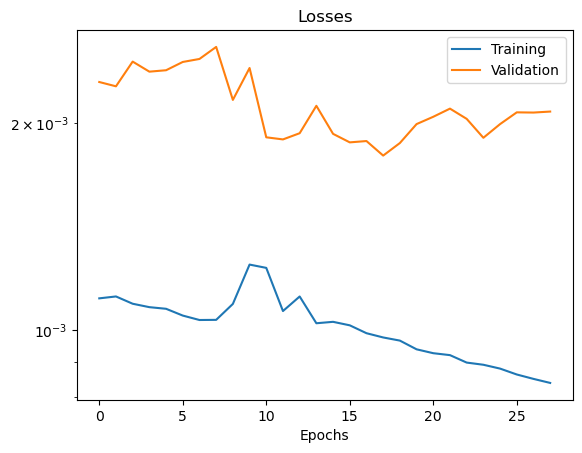

In [34]:
plt.plot(train_losses, label='Training')
plt.plot(validation_losses, label='Validation')
plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Visualizing Test Sample and Predicted Water Depth

<b>Selecting a Test Sample</b>

Here, a specific test sample is selected (data_id = 2) from the test dataset. The input data (x) and the ground truth water depth (WD) are prepared for visualization. Also, the shapes of the input data tensor (x) and the water depth tensor (WD) is printed for inspection.

In [35]:
# select one sample
data_id = 2

x = test_dataset[data_id][0].unsqueeze(0)
x = x.float().to(device)
WD = test_dataset[data_id][1]

# Display the shapes of the input data and water depth tensor
print(f"Shape of input data (x): {x.shape}")
print(f"Shape of water depth (WD): {WD.shape}")

Shape of input data (x): torch.Size([1, 4, 64, 64])
Shape of water depth (WD): torch.Size([48, 64, 64])


<b>Visualizing Input Data Channels</b>

Next, we visualize the input data channels (e.g., terrain elevation, slope in x and y directions) using different colormaps. Individual plots are generated for each channel, providing a visual representation of the input features.

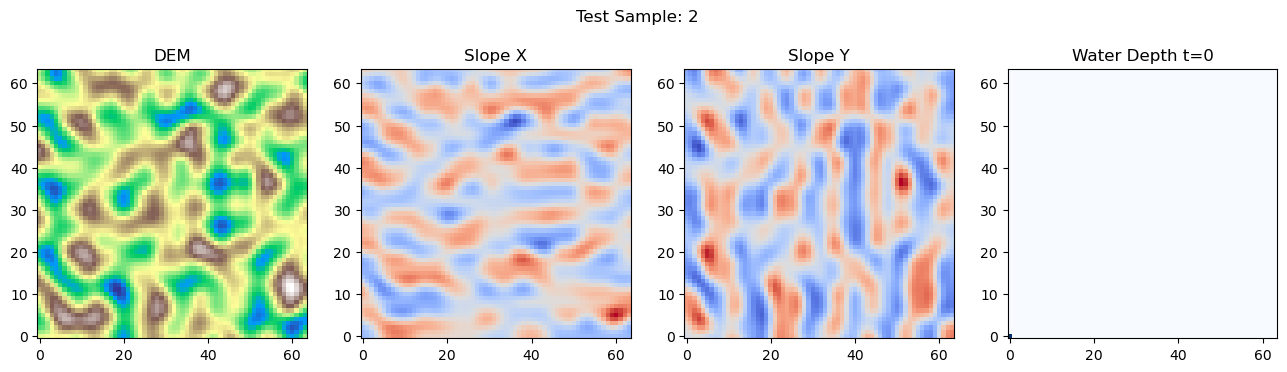

In [36]:
# Assuming the first plot represents terrain, and the subsequent plots use different colormaps
colormaps = ['terrain', 'coolwarm', 'coolwarm', 'Blues']

# Define titles for each channel
channel_titles = ['DEM', 'Slope X', 'Slope Y', f'Water Depth t={t0}']

# Plotting the input tensor (x)
x_np = x.squeeze(0).cpu().numpy()  # Convert tensor to NumPy array and remove the batch dimension
num_channels = x_np.shape[0]  # Number of channels in the input

# Plot each channel separately with different colormaps and titles
fig, axs = plt.subplots(1, num_channels, figsize=(4 * num_channels, 4))
for i in range(num_channels):
    axs[i].imshow(x_np[i], cmap=colormaps[i], origin='lower')  # Set origin to lower left and use different colormaps
    axs[i].set_title(channel_titles[i])  # Set individual titles for each channel
plt.suptitle(f'Test Sample: {data_id}')
plt.show()

<b>Visualizing Water Depth Over Time</b>

Next, the ground truth water depth tensor (WD) is visualized over time. The code generates plots for specific time steps, allowing for the examination of how water depth evolves over the given sequence.

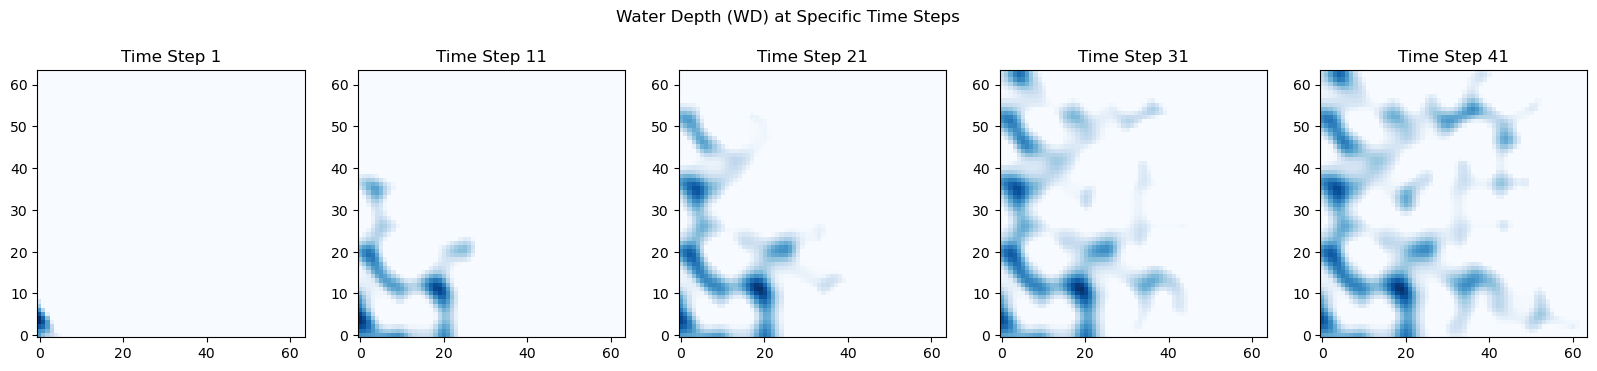

In [37]:
# Plotting the WD tensor
WD_np = WD.cpu().numpy()  # Convert tensor to NumPy array

# Assuming WD is a sequence of images (96 time steps)
num_time_steps = WD_np.shape[0]

# Plotting specific time steps (e.g., every 10th time step)
time_steps_to_plot = list(range(0, num_time_steps, 10))

fig, axs = plt.subplots(1, len(time_steps_to_plot), figsize=(4 * len(time_steps_to_plot), 4))
for i, timestep in enumerate(time_steps_to_plot):
    axs[i].imshow(WD_np[timestep], cmap='Blues', origin='lower')  # Set origin to lower left
    axs[i].set_title(f"Time Step {timestep + 1}")
plt.suptitle("Water Depth (WD) at Specific Time Steps")
plt.show()

<b>Predicting Water Depth and Visualization</b>

Finally, the neural network model predicts the water depth (pred_WD) for the selected test sample. The predicted water depth is then visualized over specific time steps, providing a comparison between the ground truth and predicted values.

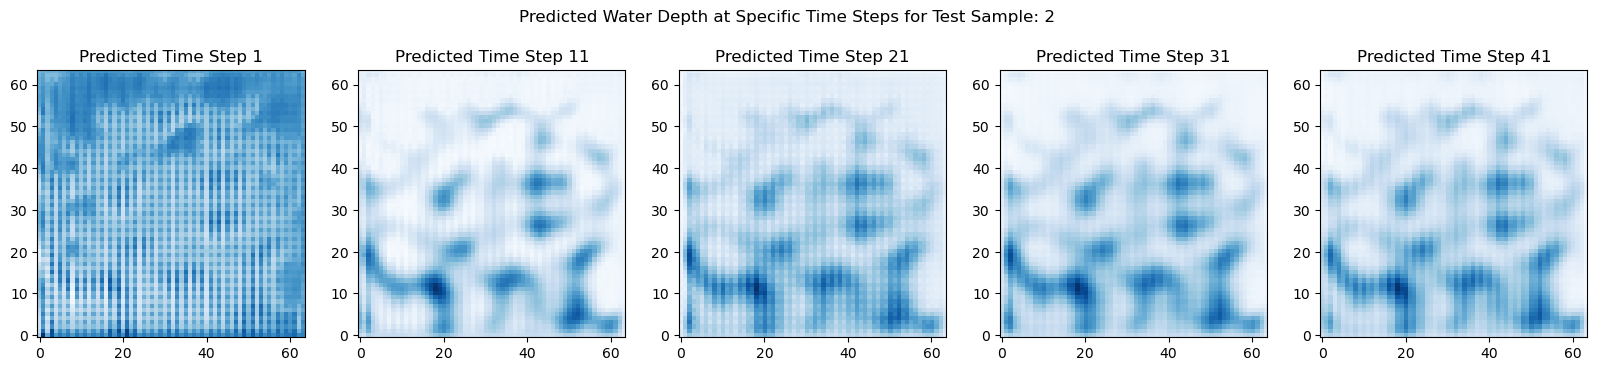

In [38]:
# predict the WD
pred_WD = model(x).detach()

# Convert the predicted tensor to numpy array
pred_WD_np = pred_WD.squeeze(0).cpu().numpy()  # Assuming batch dimension needs to be squeezed

# Plotting specific time steps (e.g., every 10th time step)
time_steps_to_plot_pred = list(range(0, pred_WD_np.shape[0], 10))

fig, axs = plt.subplots(1, len(time_steps_to_plot_pred), figsize=(4 * len(time_steps_to_plot_pred), 4))
for i, timestep in enumerate(time_steps_to_plot_pred):
    axs[i].imshow(pred_WD_np[timestep], cmap='Blues', origin='lower')  # Assuming 'viridis' colormap, change as needed
    axs[i].set_title(f"Predicted Time Step {timestep + 1}")
plt.suptitle(f'Predicted Water Depth at Specific Time Steps for Test Sample: {data_id}')
plt.show()

In [39]:
# # Reshaping for the case of 96 timesteps
# DEM = scaler_x.inverse_transform(x[0].reshape(4, -1).T.cpu())[:, 0].reshape(64, 64)
# real_WD = scaler_y.inverse_transform(WD.reshape(96, -1).cpu()).reshape(96, 64, 64)
# pred_WD = scaler_y.inverse_transform(pred_WD.reshape(96, -1).cpu()).reshape(96, 64, 64)


In [40]:
# import matplotlib.pyplot as plt

# # Assuming pred_WD contains the predicted water depths with shape (96, 64, 64)
# num_time_steps = 4  # Number of time steps to plot

# fig, axs = plt.subplots(1, num_time_steps, figsize=(12, 3))

# for i in range(num_time_steps):
#     axs[i].imshow(pred_WD[i], cmap='viridis')  # Adjust the colormap as needed
#     axs[i].set_title(f"Time Step {i+1}")

# plt.tight_layout()
# plt.show()


In [41]:
# import matplotlib.pyplot as plt

# # Assuming pred_WD contains the predicted water depths with shape (96, 64, 64)
# num_time_steps = 50  # Number of time steps to plot
# sample_index = 0  # Index of the sample to visualize

# fig, axs = plt.subplots(5, 10, figsize=(15, 8))

# for i in range(5):
#     for j in range(10):
#         timestep = i * 10 + j
#         if timestep < num_time_steps:
#             axs[i, j].imshow(pred_WD[timestep], cmap='viridis')  # Adjust the colormap as needed
#             axs[i, j].set_title(f"Time Step {timestep + 1}")

# plt.tight_layout()
# plt.show()
